In [1]:
import pandas as pd

# Load the Excel file into a DataFrame
file_path = "/Users/marclambertes/Downloads/Database Men 2023-2024/Bundesliga - 2023-2024.xlsx"
df = pd.read_excel(file_path)

# Create a new metric: total defensive actions
df['total_defensive_actions'] = (
    df['Aerial duels per 90'] + 
    df['Defensive duels per 90'] + 
    df['Sliding tackles per 90'] + 
    df['Interceptions per 90'] + 
    df['Shots blocked per 90']
)

# Calculate the Proactive defensive score as interceptions % of the total defensive actions
df['proactive_defensive_score'] = df['Interceptions per 90'] / df['total_defensive_actions']

# Calculate the Reactive defensive score as sliding tackles % of the total defensive actions
df['reactive_defensive_score'] = df['Sliding tackles per 90'] / df['total_defensive_actions']

# Calculate the ratio of proactive to reactive actions
df['proactive_to_reactive_ratio'] = df['proactive_defensive_score'] / df['reactive_defensive_score']

# Normalize this ratio to a 0-100 scale
# Assuming you want to map the ratio to a score where 0 is completely reactive and 100 is completely proactive
df['proactivity_score'] = 100 * df['proactive_to_reactive_ratio'] / (1 + df['proactive_to_reactive_ratio'])

# Optionally, you can save the DataFrame back to an Excel file or inspect the DataFrame
df.to_excel("/Users/marclambertes/Downloads/DA_LL_with_proactivity_score.xlsx", index=False)
print(df.head())  # to check the new columns


       Player                 Team Team within selected timeframe Position  \
0  O. Baumann           Hoffenheim                     Hoffenheim       GK   
1   F. Rønnow         Union Berlin                   Union Berlin       GK   
2  N. Atubolu             Freiburg                       Freiburg       GK   
3  M. Riemann               Bochum                         Bochum       GK   
4    W. Pacho  Eintracht Frankfurt            Eintracht Frankfurt      LCB   

   Age  Matches played  Minutes played  Goals    xG  Assists  ...  \
0   33              33            3308      0  0.00        1  ...   
1   31              32            3223      0  0.20        0  ...   
2   21              32            3219      0  0.00        0  ...   
3   35              32            3195      0  0.00        0  ...   
4   22              32            3185      0  1.11        2  ...   

   Direct free kicks per 90  Direct free kicks on target, %  Corners per 90  \
0                       NaN          

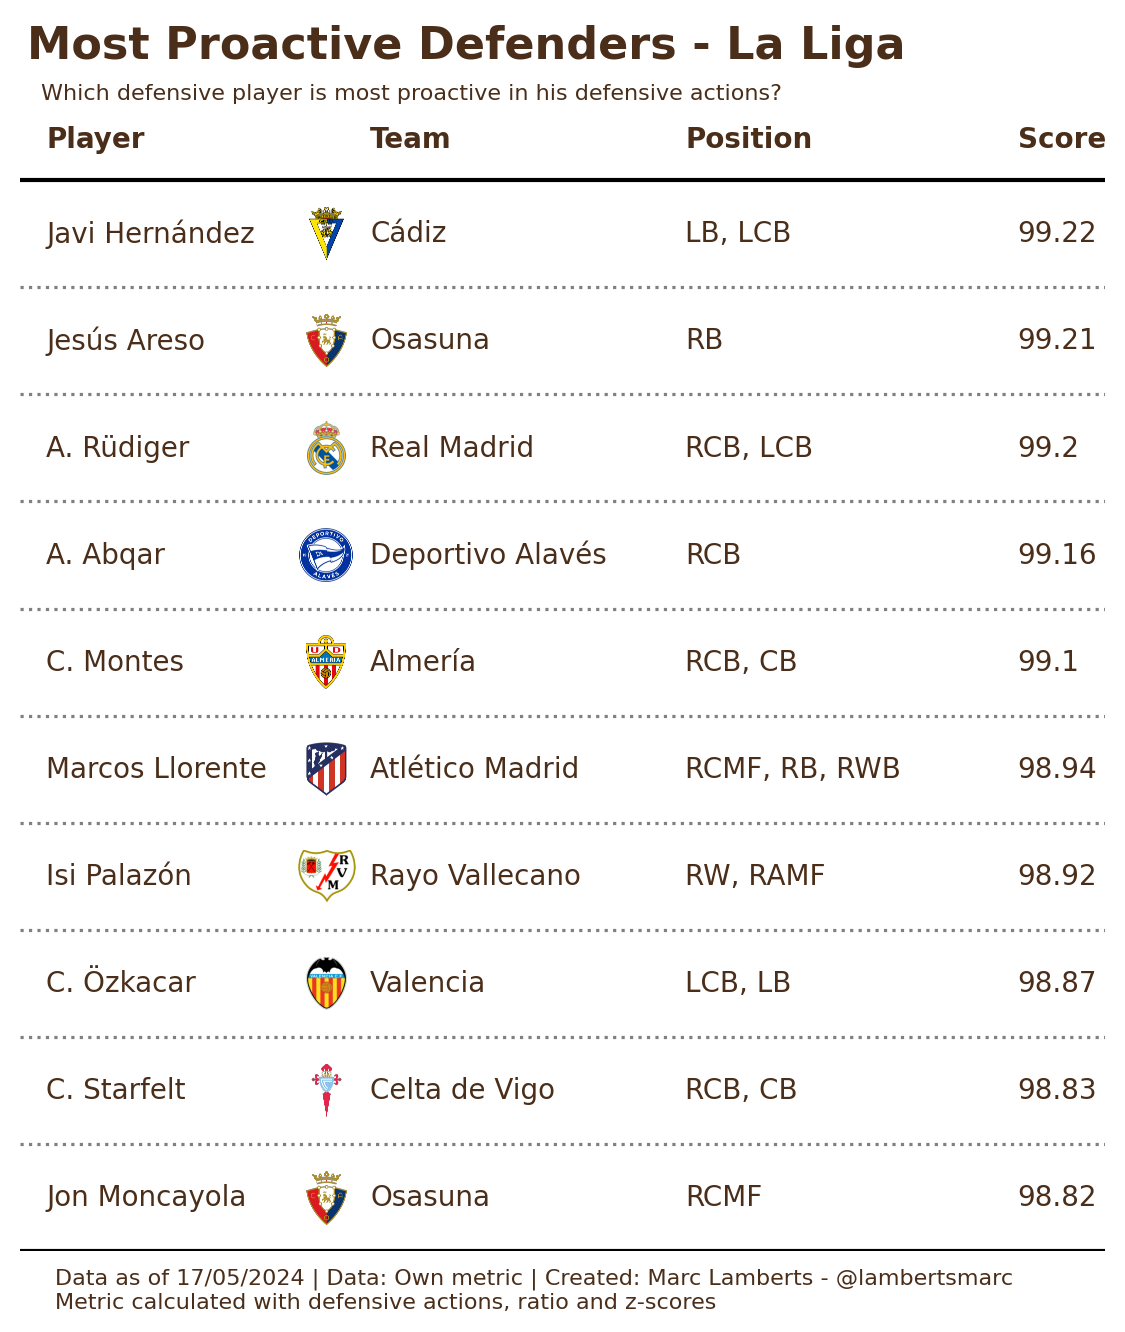

In [12]:
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter


df = pd.read_excel('/Users/marclambertes/Downloads/DA_LL_with_proactivity_score.xlsx')
df = df.rename(columns={'proactivity_score': 'Score'})
df['Score'] = (df['Score']).round(2)
#df = df.rename(columns={'playerName': 'Player'})
df = df.sort_values(by='Score', ascending=False).head(10)


def ax_logo(team, ax,):
    path = r'/Users/marclambertes/Downloads/Images'
    club_icon = Image.open('%s/%s.png' %(path,team))
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

indexdf = df.head(10)[['Player', 'Team', 'Position', 'Score']].reset_index(drop=True)
indexdf_short=indexdf[::-1]


fig = plt.figure(figsize=(7,8), dpi=200)
ax = plt.subplot()

ncols = len(indexdf_short.columns.tolist())+1
nrows = indexdf_short.shape[0]

ax.set_xlim(0, ncols + 1.2)
ax.set_ylim(0, nrows + 1.5)

# lgs = ['J1', 'J2', 'Ekstraklasa', 'J3']
# if lg in lgs:
positions = [0.15, 2.0, 3.8, 5.7]
# else:
#     positions = [0.25, 2.25, 3.75, 4.5, 5.25]
columns = indexdf_short.columns.tolist()

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if 'xG per 90' in column:
            text_label = f'{indexdf_short[column].iloc[i]:,.2f}'
            weight = 'regular'
        else:
            text_label = f'{indexdf_short[column].iloc[i]}'
            weight = 'regular'
        ax.annotate(
            xy=(positions[j], i + .5),
            text = text_label,
            ha='left',
            va='center', color='#4A2E19',
            weight=weight
        )

# Add column names
column_names = columns
for index, c in enumerate(column_names):
        ax.annotate(
            xy=(positions[index], nrows + .25),
            text=column_names[index],
            ha='left',
            va='bottom',
            weight='bold', color='#4A2E19'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

ax.set_axis_off()

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
# -- Add nation axes
ax_point_1 = DC_to_NFC([2.25, 0.25])
ax_point_2 = DC_to_NFC([2.75, 0.75])
ax_width = abs(ax_point_1[0] - ax_point_2[0])
ax_height = abs(ax_point_1[1] - ax_point_2[1])
for x in range(0, nrows):
    ax_coords = DC_to_NFC([1.5, x + .25])
    flag_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_width, ax_height]
    )
    ax_logo(indexdf_short['Team'].iloc[x], flag_ax,)

fig.text(
    x=0.13, y=.85,
    s='Most Proactive Defenders - La Liga',
    ha='left',
    va='bottom',
    weight='bold',
    size=16, color='#4A2E19'
)
fig.text(
    x=0.15, y=0.10,
    s='Data as of 17/05/2024 | Data: Own metric | Created: Marc Lamberts - @lambertsmarc\nMetric calculated with defensive actions, ratio and z-scores',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

fig.text(
    x=0.14, y=0.84,
    s='Which defensive player is most proactive in his defensive actions?',
    ha='left',
    va='top',
    weight='regular',
    size=8, color='#4A2E19'
)

plt.savefig('PDS - LL.png',dpi=750,bbox_inches = 'tight', facecolor='white')
#plt.savefig('Similar Players - Momiki.pdf', dpi=750, bbox_inches='tight', facecolor='white')